# **VAE face generation - CelebA dataset**

## **Connect to google drive**

In [1]:
from google.colab import drive
drive.mount('/content/google_drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/google_drive


## **Download dataset from Kaggle directly to GC virtual machine**

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# file_path is the path where kaggle.json is present in the Google Drive

In [ ]:
%cd /content
%pwd
%ls

Place kaggle.json in the content folder 

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

## **Variational Autoencoder class**

In [ ]:
%tensorflow_version 1.x
from PIL import Image
import keras  
import matplotlib.pyplot as plt
import os

def save_to_disk(txt_path, values):
    if os.path.isfile(txt_path):
        os.remove(txt_path)
    with open(txt_path, "wb") as fp:   
        pickle.dump(values, fp)
    return
def load_from_disk(txt_path):
    with open(txt_path, "rb") as f:
        values =  pickle.load(f)
    return values

class ReconstructFaceCallback(keras.callbacks.Callback):
    def __init__(self, save_path, VAE):
        self.save_path = save_path
        self.VAE = VAE
    def on_epoch_end(self, epoch, logs={}):
        example_ind = 10
        image_path = os.path.join("img_align_celeba/img_align_celeba",str(example_ind).zfill(6)+".jpg")
        pil_image = Image.open(image_path)
        pil_image = pil_image.resize((INPUT_DIMS[0],INPUT_DIMS[1]), Image.ANTIALIAS)
        image = np.array(pil_image)/255.

        latent_space = self.VAE.encoder.predict(np.expand_dims(image,0))
        reconstructed_image = self.VAE.decoder.predict(latent_space)
        plt.figure()
        plt.imshow(reconstructed_image.squeeze())
        plt.show()
        plt.imsave(os.path.join(self.save_path, "reconstructed_{}.jpg".format(epoch)),reconstructed_image.squeeze())

In [7]:
import numpy as np
import os
import keras
from keras.layers import Input,Conv2D,Conv2DTranspose,LeakyReLU,Flatten,Dropout,Dense,Lambda,BatchNormalization,Reshape,Activation
from keras.models import load_model, Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
from keras.utils import plot_model
import keras.backend as K

class VariationalAutoencoder(object):
    def __init__(self):
        self.nothing = 10
    def __init__(self,
                 input_dims,
                 latent_space_size,
                 encoder_filters,
                 encoder_kernel_size,
                 encoder_strides,
                 encoder_padding,
                 decoder_filters,
                 decoder_kernel_size,
                 decoder_strides,
                 decoder_padding
                 ):
        self.input_dims = input_dims
        self.latent_space_size = latent_space_size
        self.encoder_filters = encoder_filters
        self.encoder_kernel_size = encoder_kernel_size
        self.encoder_strides = encoder_strides
        self.encoder_padding = encoder_padding
        self.decoder_filters = decoder_filters
        self.decoder_kernel_size = decoder_kernel_size
        self.decoder_strides = decoder_strides
        self.decoder_padding = decoder_padding
        self._create_model()
    def _create_model(self):
        self.images = Input(shape=self.input_dims, name="images")
        # create encoder as separate model      
        encoder_shape_before_flattening = self._create_encoder()
        # create decoder as separate model
        self.decoder_input = Input(shape=(self.latent_space_size,), name="decoder_input")
        self._create_decoder(encoder_shape_before_flattening)
        # create unique model 
        self.model = Model(inputs=self.images, outputs=self.decoder(self.encoder_output))

    def _create_encoder(self):
        # create convolutional layers for encoder
        X = self.images
        for i in range(len(self.encoder_filters)):
            X = self._create_conv_layer(X,
                                        "Conv2D",
                                        self.encoder_filters[i],
                                        self.encoder_kernel_size[i],
                                        self.encoder_strides[i],
                                        self.encoder_padding[i],
                                        "encoder_conv"+str(i)
                                        )
        # keep track of tensor shape before flattening (we will need this to build decoder)
        encoder_shape_before_flattening = K.int_shape(X)[1:]
        # flatten the tensor
        X = Flatten()(X)
        # create dense layers for mu and sigma
        self.encoder_mu = Dense(units=self.latent_space_size, name='encoder_mu')(X)
        self.encoder_log_var = Dense(units=self.latent_space_size, name='encoder_log_var')(X)
        self.encoder_parameters = Model(self.images, (self.encoder_mu, self.encoder_log_var))
        # create encoder output by sampling from normal distribution
        self.encoder_output = Lambda(self.sample_latent_space,name="encoder_output")([self.encoder_mu,self.encoder_log_var])
        self.encoder = Model(inputs=self.images, outputs=self.encoder_output)
        return encoder_shape_before_flattening
    def _create_decoder(self, encoder_shape_before_flattening):
        X = Dense(np.prod(encoder_shape_before_flattening))(self.decoder_input)
        X = Reshape(encoder_shape_before_flattening)(X)
        # create convolutional layers for decoder
        for i in range(len(self.decoder_filters)):
            is_not_last_layer = i < len(self.decoder_filters)-1
            X = self._create_conv_layer(X,
                                        "Conv2DTranspose",
                                        self.decoder_filters[i],
                                        self.decoder_kernel_size[i],
                                        self.decoder_strides[i],
                                        self.decoder_padding[i],
                                        "decoder_conv"+str(i),
                                        batch_norm=is_not_last_layer,
                                        dropout=is_not_last_layer,
                                        activation=is_not_last_layer
                                        )
        # output values should be between 0 and 1
        self.decoder_output = Activation("sigmoid")(X)
        self.decoder = Model(inputs=self.decoder_input, outputs=self.decoder_output)
    def _create_conv_layer(self,input,convolution_type,filters,kernel_size,strides,padding,name,batch_norm=True,dropout=True,activation=True):
        convolution = getattr(keras.layers, convolution_type) # sets Conv2D or Conv2DTranspaose
        conv_layer = convolution(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding = padding,
            name = name
            )
        X = conv_layer(input)
        if batch_norm:
            X = BatchNormalization()(X)
        if activation:
            X = LeakyReLU()(X)
        if dropout:
            X = Dropout(rate=0.25)(X)
        return X
    def sample_latent_space(self, mu_and_log_var):
        mu, log_var = mu_and_log_var
        normal_samples = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * normal_samples
    def compile(self,optimizer, r_loss_factor):
        self.model.compile(optimizer=optimizer, loss=self.penalized_loss(r_loss_factor), metrics=[self.penalized_loss(r_loss_factor)])
    def penalized_loss(self,r_loss_factor):
        def loss(y, y_hat):
            # reconstruction_loss
            r_loss = K.mean(K.square(y-y_hat),axis=[1,2,3]) # dont do mean on batch axis
            # KL loss
            kl_loss = -0.5 * K.sum(1 + self.encoder_log_var - K.square(self.encoder_mu) - K.exp(self.encoder_log_var), axis = 1)    
            return r_loss*r_loss_factor + kl_loss
        return loss
    def train(self,save_path, data_flow, epochs, steps_per_epoch, initial_epoch = 0, lr_decay = 1, learning_rate=0.0005):
        learning_rate_schedule = self.step_decay_schedule(initial_lr=learning_rate, decay_factor=lr_decay, step_size=1)
        history_logger = CSVLogger(os.path.join(save_path, "history.csv"), append=True)
        checkpoint_model = ModelCheckpoint(os.path.join(save_path, "model.h5"), verbose=1)
        checkpoint_weights = ModelCheckpoint(os.path.join(save_path, "weights.h5"), save_weights_only=True, verbose = 1)
        checkpoint_encoder = ModelCheckpoint(os.path.join(save_path, "encoder.h5"), verbose=1)
        checkpoint_encoder.set_model(self.encoder)
        checkpoint_decoder = ModelCheckpoint(os.path.join(save_path, "decoder.h5"), verbose=1)
        checkpoint_decoder.set_model(self.decoder)
        reconstruct_callback = ReconstructFaceCallback(os.path.join(save_path,"plots"), self)
        history = self.model.fit_generator(
            data_flow,
            shuffle = True,
            epochs = epochs,
            initial_epoch = initial_epoch,
            steps_per_epoch = steps_per_epoch,
            callbacks = [learning_rate_schedule,
                         history_logger,
                         checkpoint_weights,
                         checkpoint_model,
                         checkpoint_encoder,
                         checkpoint_decoder,
                         reconstruct_callback
                         ],
            verbose=1
            )
        return history
    def step_decay_schedule(self,initial_lr, decay_factor, step_size):
        def schedule(epoch):
            return initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return LearningRateScheduler(schedule)
    def load_trained_model(self, load_path, r_loss_factor):
        self.model = load_model(os.path.join(load_path, "model.h5"), custom_objects={"loss": self.penalized_loss(r_loss_factor),"sample_latent_space":self.sample_latent_space})
        #self.encoder = load_model(os.path.join(load_path, "encoder.h5"), custom_objects={"loss": self.penalized_loss(r_loss_factor),"sample_latent_space":self.sample_latent_space})
        #self.decoder = load_model(os.path.join(load_path, "decoder.h5"), custom_objects={"loss": self.penalized_loss(r_loss_factor),"sample_latent_space":self.sample_latent_space})
    def load_trained_weights(self, load_path):
        self.model.load_weights(os.path.join(load_path, "weights.h5"))
    def plot_model(self,plots_path):
        plots_path = os.path.join(plots_path, "plots")
        os.makedirs(plots_path, exist_ok=True)
        plot_model(self.model, to_file=os.path.join(plots_path,'model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(plots_path,'encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(plots_path,'decoder.png'), show_shapes = True, show_layer_names = True)
        print("Models are ploted in {}".format(plots_path))

## **Create the model**

In [ ]:
from keras.optimizers import Adam
OPTIMIZER=Adam(lr=0.0005)
R_LOSS_FACTOR = 10000
INPUT_DIMS = (128,128,3)
EPOCHS = 200
INITIAL_EPOCH = 0
BATCH_SIZE = 32
LATENT_SPACE_SIZE = 200
VAE = VariationalAutoencoder(
    input_dims=INPUT_DIMS,
    latent_space_size=LATENT_SPACE_SIZE,
    encoder_filters=[32,64,64,64],
    encoder_kernel_size=[3,3,3,3],
    encoder_strides=[2,2,2,2],
    encoder_padding = ["same","same","same","same"],
    decoder_filters=[64,64,32,3],
    decoder_kernel_size=[3,3,3,3],
    decoder_strides=[2,2,2,2],
    decoder_padding=["same","same","same","same"]
    )
print("Encoder and decoder model summary:")
VAE.encoder.summary()
VAE.decoder.summary()

VAE.compile(OPTIMIZER, R_LOSS_FACTOR)
VAE.plot_model("google_drive/My Drive/Colab Notebooks")

## **Train**


### Continue Training

**!!! RUN THIS ONLY IF YOU WANT TO CONTINUE WITH TRAINED WEIGHTS !!!**

In [10]:
VAE.load_trained_weights("google_drive/My Drive/Colab Notebooks")
INITIAL_EPOCH = 171

### Start training

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import os
# path to the FOLDER contatining images
DATA_PATH = os.path.join(os.getcwd(), "img_align_celeba") 
file_names = []
for file_name in os.listdir(os.path.join(DATA_PATH,"img_align_celeba")):
    file_names.append(file_name)
DATASET_SIZE = len(file_names)
# create image generator and data flow
data_generator = ImageDataGenerator(rescale=1./255)
data_flow = data_generator.flow_from_directory(
    DATA_PATH,
    target_size = INPUT_DIMS[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = "training"
    )
# train the VAE with fit_generator
history = VAE.train(   
    save_path = "google_drive/My Drive/Colab Notebooks",
    data_flow = data_flow,
    epochs = EPOCHS,
    steps_per_epoch = DATASET_SIZE / BATCH_SIZE,
    initial_epoch = INITIAL_EPOCH,
    learning_rate = 0.0005
)
# plot loss 
plt.figure()
plt.plot(history.history['loss'], 'b')
plt.title("Training VAE loss")
plt.show()

## **Test** 

In [9]:
# load pretrained weights
VAE.load_trained_weights("google_drive/My Drive/Colab Notebooks")

In [10]:
from PIL import Image
import os
import numpy as np

def loadImage(folder_path, example_ind, INPUT_DIMS=(128,128,3)):
    image_path = os.path.join(folder_path, str(example_ind).zfill(6)+".jpg")
    pil_image = Image.open(image_path)
    pil_image = pil_image.resize((INPUT_DIMS[0],INPUT_DIMS[1]), Image.ANTIALIAS)
    image = np.array(pil_image)/255.
    return image

### Reconstruct faces

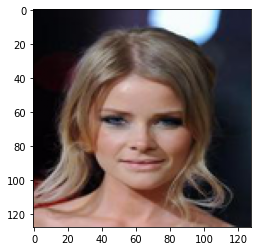

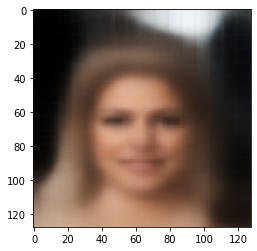

In [13]:
import matplotlib.pyplot as plt

example_ind = 10 # za 3 fail, 2000 OK
image = loadImage("img_align_celeba/img_align_celeba", example_ind)

latent_space = VAE.encoder.predict(np.expand_dims(image,0))
reconstructed_image = VAE.decoder.predict(latent_space)

plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(reconstructed_image.squeeze())

### Generate new faces

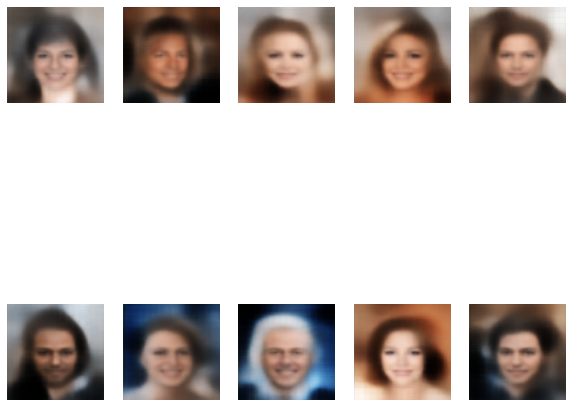

In [252]:
number_of_images = 10
# sample from normal distribution
latent_space = np.random.normal(size=(number_of_images,LATENT_SPACE_SIZE))
# generate new image from latent space
generated_image = VAE.decoder.predict(latent_space)
# plot the images
fig = plt.figure(figsize=(10,10))
for i in range(number_of_images):
    ax = fig.add_subplot(2, number_of_images/2, i+1)
    ax.imshow(generated_image[i, :,:,:])
    ax.axis('off')
plt.show()

## **Distribution of points in latent space**

### Distributions of separate dimensions in latent space

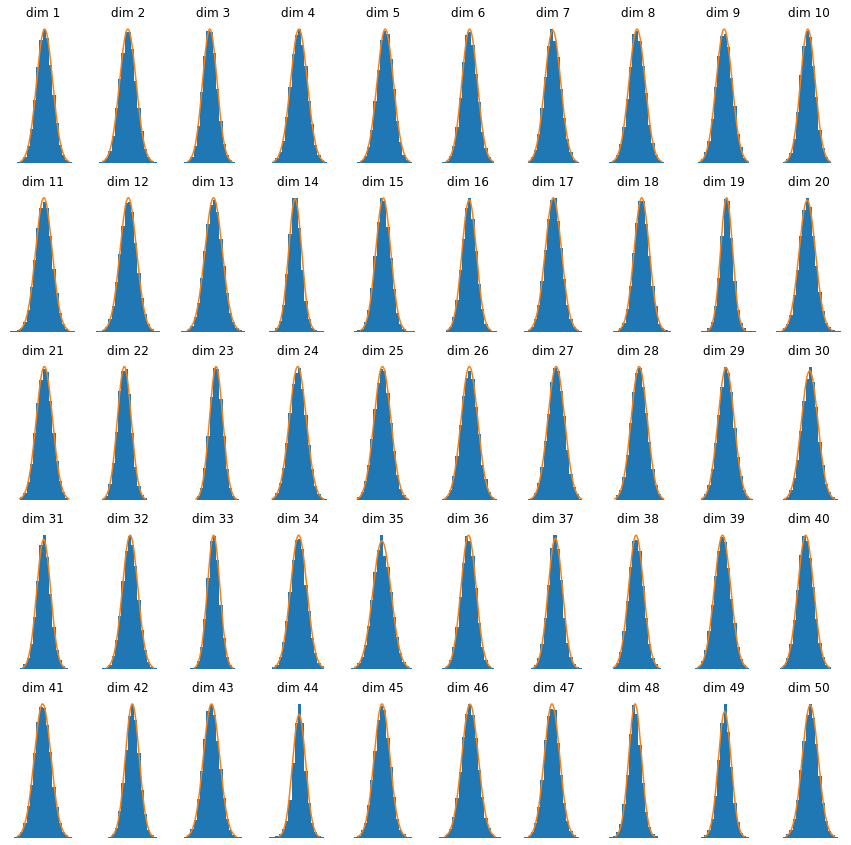

In [11]:
from scipy.stats import norm

number_of_images = 20000 # the more images you choose, the better will be approximation
number_of_dimensions = 50
# Load images
images = np.zeros((number_of_images,)+INPUT_DIMS)
for i in range(number_of_images):
    images[i,:,:,:] = loadImage("img_align_celeba/img_align_celeba", np.random.randint(1, 202600))
# get latent space by passing images through encoder
latent_space = VAE.encoder.predict(images)
# plot distribution of points in each dimension
fig = plt.figure(figsize=(15, 15))
for i in range(number_of_dimensions):
    ax = fig.add_subplot(number_of_dimensions/10, 10, i+1)
    ax.hist(latent_space[:,i], density=True, bins = 20)
    ax.set_title(loc='center', label='dim {}'.format(i+1))
    x = np.linspace(-3,3,200)
    y = norm.pdf(np.linspace(-3,3,200))
    ax.plot(x, y)
    ax.axis('off')
plt.show()
del images

### Distribution of latent space

Visualising normal distribution of latent space using t-SNE (2D)

In [12]:
from sklearn.manifold import TSNE
# it takes some time to reduce the dimensions with t-SNE
latent_space_embedded = TSNE(n_components=2).fit_transform(latent_space)

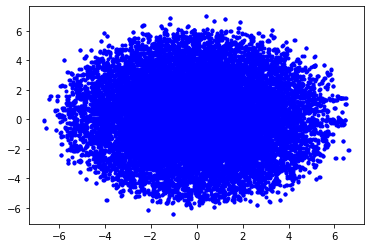

In [13]:
# plot in 2D
plt.plot(latent_space_embedded[:,0],latent_space_embedded[:,1], 'b.')
plt.show()

Visualising normal distribution of latent space using t-SNE (3D)

In [ ]:
import plotly.graph_objects as go
from plotly.io import write_image
from sklearn.manifold import TSNE

def bin_centers(bins):
    centers = (bins + (bins[1]-bins[0])/2) [:-1]    
    return centers

In [ ]:
x = latent_space_embedded[:,0]
y = latent_space_embedded[:,1]
h, x_edges, y_edges = np.histogram2d(x, y, bins=50, density=True)
x_bins_centers = bin_centers(x_edges)
y_bins_centers = bin_centers(y_edges)
# plot in 3D using plotly

fig = go.Figure(data=[go.Surface(x=x_bins_centers, y=y_bins_centers, z=h)])
fig.show()

## **Vector arithmetic in latent space**

In [166]:
import pandas as pd
from numpy.linalg import norm

def getVectorsFromLabels(labels, VAE, data_path, DATASET_SIZE, LATENT_SPACE_SIZE, min_num_pos=10000):
    IMAGE_PATH = os.path.join(data_path, 'img_align_celeba/img_align_celeba')
    attributes = pd.read_csv(os.path.join(data_path, 'list_attr_celeba.csv'))
    attr_num_pos = [0]*len(labels)
    attr_num_neg = [0]*len(labels)
    vectors_pos = [np.zeros(shape=(1,LATENT_SPACE_SIZE), dtype='float32')]*len(labels)
    vectors_neg = [np.zeros(shape=(1,LATENT_SPACE_SIZE), dtype='float32')]*len(labels)
    for i in range(1,DATASET_SIZE-1):
        # check condition
        if all(num > min_num_pos for num in attr_num_pos):
            break
        # load image, get latent space and delete it
        image = loadImage(IMAGE_PATH, example_ind=i)
        latent_space = VAE.encoder.predict(np.expand_dims(image,0))
        if i % 100 == 0:
            print ("\rimage {}/{}, number of positives: {}, min num is {}".format(i,DATASET_SIZE,attr_num_pos,min_num_pos),end='')
        del image # free memory
        for label_ind,label in enumerate(labels):
            if label not in attributes.columns:
                raise ValueError("### Label {} is incorrect! ###".format(label))
            # get attribute value
            attr_value = attributes.loc[i-1, label]
            # add vectors
            if attr_value == 1: # if attribute is on image
                attr_num_pos[label_ind] += 1
                vectors_pos[label_ind] = vectors_pos[label_ind] + latent_space
            else: # if attribute is not on image
                attr_num_neg[label_ind] += 1
                vectors_neg[label_ind] = vectors_neg[label_ind] + latent_space
    # divide vectors by number on examples and subtract negative vector from positive
    vectors = []
    for label_ind in range(len(labels)):
        positive_vector = vectors_pos[label_ind]/attr_num_pos[label_ind]
        negative_vector = vectors_neg[label_ind]/attr_num_neg[label_ind]
        vector = positive_vector - negative_vector
        vectors.append(vector/norm(vector))
    return vectors

In [168]:
labels = ['Male', 'Smiling', 'Eyeglasses', 'Blond_Hair','Young']
# this takes some time to execute (depends on the min num of positives)
male_vec,smiling_vec,eyeglasses_vec,blond_hair_vec,young_vec = getVectorsFromLabels(labels,VAE,os.getcwd(),202600,LATENT_SPACE_SIZE,1000)

image 15000/202600, number of positives: [6332, 7225, 994, 2212, 11668], min num is 1000

In [189]:
def addVectorToLatentSpace(vector, VAE, image_ind, images_path):
    factors = [-4,-3,-2,-1,0,1,2,3,4]
    fig = plt.figure(figsize=(25,25))
    image = loadImage(images_path, image_ind)
    latent_space = VAE.encoder.predict(np.expand_dims(image,0))
    for i,factor in enumerate(factors):
        ax = fig.add_subplot(1,len(factors),i+1)
        new_latent_space = latent_space + factor*vector
        new_image = VAE.decoder.predict(new_latent_space)
        ax.imshow(new_image.squeeze())
        ax.axis('off')
        ax.set_title(loc='center', label = ' {} '.format(factor),fontsize=15)
    plt.show()
    return 

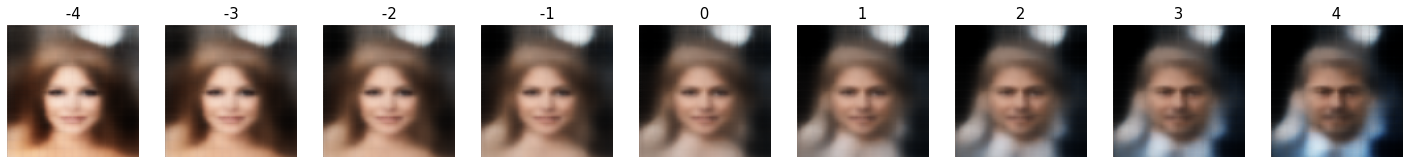

In [218]:
# Male vector
addVectorToLatentSpace(male_vec, VAE, 10, "img_align_celeba/img_align_celeba")

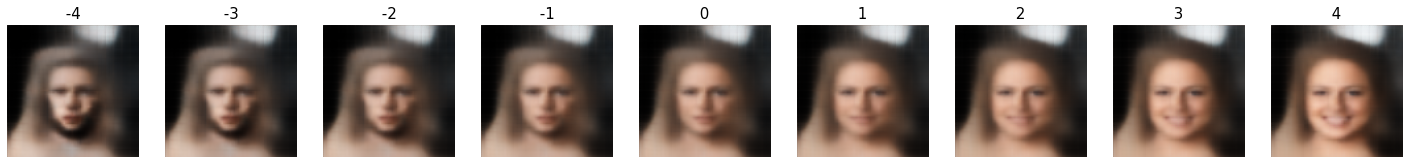

In [219]:
# Smiling vector
addVectorToLatentSpace(smiling_new, VAE, 10, "img_align_celeba/img_align_celeba")

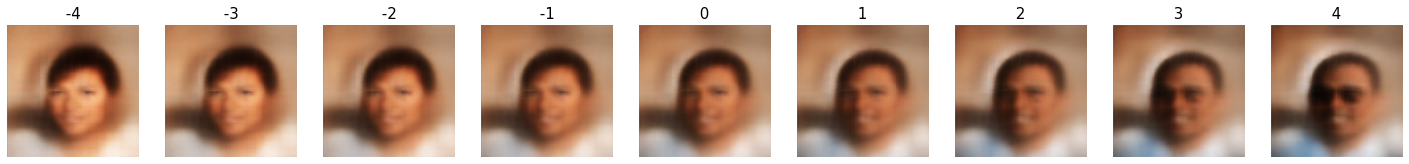

In [195]:
# Eyeglasses vector
addVectorToLatentSpace(eyeglasses_vec, VAE, 2000, "img_align_celeba/img_align_celeba")

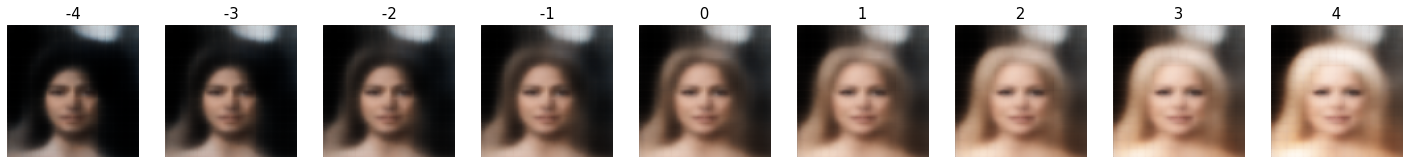

In [214]:
# Blond hair vector
addVectorToLatentSpace(blond_hair_vec, VAE, 10, "img_align_celeba/img_align_celeba")

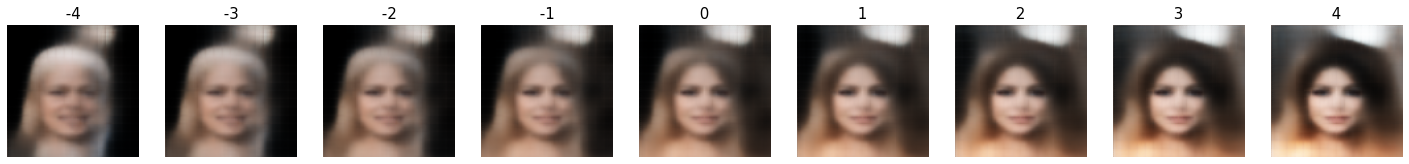

In [216]:
# Young vector
addVectorToLatentSpace(young_vec, VAE, 10, "img_align_celeba/img_align_celeba")

## **Morph between faces**

In [231]:
def morphBetweenImages(example_ind1, example_ind2, VAE, images_path, num_of_morphs):
    # load images
    img1 = loadImage(images_path, example_ind1)
    img2 = loadImage(images_path, example_ind2)
    # define alpha 
    alpha = np.linspace(0,1,num_of_morphs)
    # get latent spaces
    z1 = VAE.encoder.predict(np.expand_dims(img1,0))
    z2 = VAE.encoder.predict(np.expand_dims(img2,0))
    # morph and plot
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(1, num_of_morphs+2, 1)
    ax.imshow(img1)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 1',fontsize=10)
    for i in range(num_of_morphs):
        z = z1*(1-alpha[i]) + z2*alpha[i]
        new_img = VAE.decoder.predict(z)
        ax = fig.add_subplot(1, num_of_morphs+2, i+2)
        ax.imshow(new_img.squeeze())
        ax.axis('off')
        ax.set_title(loc='center', label='alpha={:.2f}'.format(alpha[i]))
    ax = fig.add_subplot(1, num_of_morphs+2, num_of_morphs+2)
    ax.imshow(img2)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 2',fontsize=10)
    return

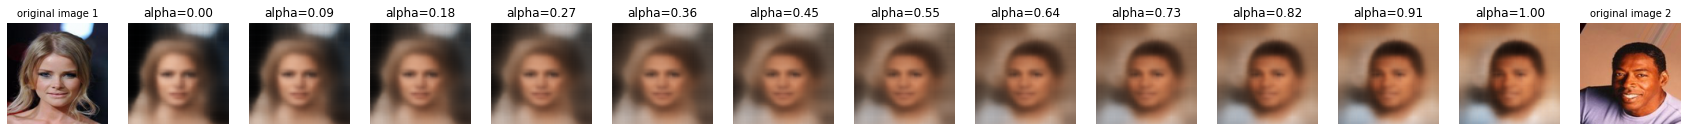

In [235]:
example_ind1 = 10
example_ind2 = 2000
num_of_morphs = 12
morphBetweenImages(example_ind1,example_ind2,VAE,"img_align_celeba/img_align_celeba",num_of_morphs)